# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

**Idea del autoencoder**

* Entrada: una imagen.
* Salida: la misma imagen, suele llamarse **reconstrucción**.

La función de costo contiene una "pérdida de reconstrucción", que penaliza al modelo cuando la reconstrucción es muy distinta del input.

En la capa del medio (una vez que ya se hizo una reducción de dimensionalidad o compresión gracias a poolings y convoluciones), se tiene una idea de cuáles son las features más importantes de la imagen de entrada.

Al hacer la reducción de dimensionalidad, el model aprende una "pseudo-identidad": aproxima la identidad solamente sobre el conjunto de datos.

Encoder: zip, Decoder: unzip.

O sea, los autoencoders son capaces de aprender representaciones eficientes de los datos de entrada, llamadas **codificaciones**.

**Convolución (o filtros):** sirven para

Importante de las convoluciones: genera varias imágenes a partir de una sola. Cada convolución se concentra en un aspecto particular.

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=fb353e7e5a909006fce40db7cc30eea5a9c79268fceea1aac7fcb36b935816bc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [ ]:
# 1.4)
# import google.colab
# from google.colab import files

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

In [6]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 196kB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.68MB/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [10]:
labels_names = dict(enumerate(train_set_orig.classes))
labels_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

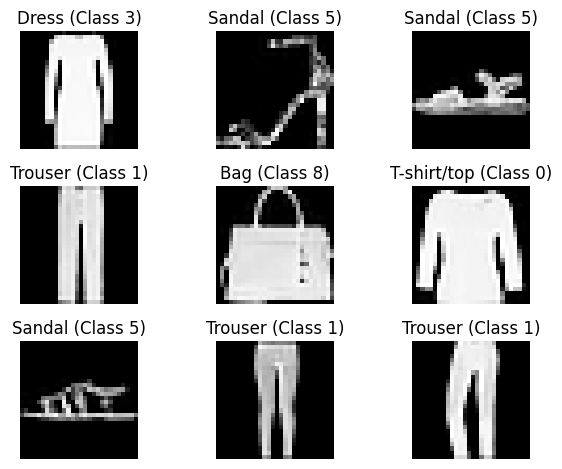

In [14]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.title(f"{labels_names[label]} (Class {label})")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.tight_layout()
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

In [ ]:
# 3.1)
class CustomDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self,i):
        pass

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

## Ejercicio 4) Red Neuronal Autoencoder Convolucional





**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

**2)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [ ]:
# 4.1)

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [ ]:
# 5.1)